# Integrator RNN Model

In this notebook, we train a vanilla RNN to integrate white noise. This example is useful on its own to understand how RNN training works.

In [1]:
from functools import partial
import matplotlib.pyplot as plt

import brainpy as bp
import brainpy.math as bm

bm.set_environment(bm.training_mode)

## Parameters

In [2]:
dt = 0.04
num_step = int(1.0 / dt)
num_batch = 128

## Data

In [3]:
@bm.jit(static_argnames=['batch_size'])
def build_inputs_and_targets(mean=0.025, scale=0.01, batch_size=10):
  # Create the white noise input
  sample = bm.random.normal(size=(batch_size, 1, 1))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(batch_size, num_step, 1))
  noise_t = scale / dt ** 0.5 * samples
  inputs = bias + noise_t
  targets = bm.cumsum(inputs, axis=1)
  return inputs, targets

In [4]:
def train_data():
  for _ in range(100):
    yield build_inputs_and_targets(batch_size=num_batch)

## Model

In [5]:
class RNN(bp.DynamicalSystem):
  def __init__(self, num_in, num_hidden):
    super(RNN, self).__init__()
    self.rnn = bp.layers.RNNCell(num_in, num_hidden, train_state=True)
    self.out = bp.layers.Dense(num_hidden, 1)

  def update(self, sha, x):
    return self.out(sha, self.rnn(sha, x))

model = RNN(1, 100)

## Training

In [6]:
# define loss function
def loss(predictions, targets, l2_reg=2e-4):
  mse = bp.losses.mean_squared_error(predictions, targets)
  l2 = l2_reg * bp.losses.l2_norm(model.train_vars().unique().dict()) ** 2
  return mse + l2


# define optimizer
lr = bp.optim.ExponentialDecay(lr=0.025, decay_steps=1, decay_rate=0.99975)
opt = bp.optim.Adam(lr=lr, eps=1e-1)


# create a trainer
trainer = bp.BPTT(model, loss_fun=loss, optimizer=opt)
trainer.fit(train_data,
            num_epoch=30,
            num_report=200)

Train 200 steps, use 6.6661 s, loss 0.03267863020300865
Train 400 steps, use 3.2480 s, loss 0.021463658660650253
Train 600 steps, use 3.2402 s, loss 0.021079201251268387
Train 800 steps, use 1.8296 s, loss 0.020880231633782387
Train 1000 steps, use 2.1118 s, loss 0.020774580538272858
Train 1200 steps, use 2.9573 s, loss 0.02063039317727089
Train 1400 steps, use 2.7842 s, loss 0.0205252543091774
Train 1600 steps, use 2.6614 s, loss 0.02043277956545353
Train 1800 steps, use 2.8362 s, loss 0.020348429679870605
Train 2000 steps, use 3.0956 s, loss 0.020263437181711197
Train 2200 steps, use 2.8724 s, loss 0.020172588527202606
Train 2400 steps, use 2.8865 s, loss 0.020098494365811348
Train 2600 steps, use 2.9206 s, loss 0.020026057958602905
Train 2800 steps, use 3.0855 s, loss 0.019952191039919853
Train 3000 steps, use 2.8707 s, loss 0.019887030124664307


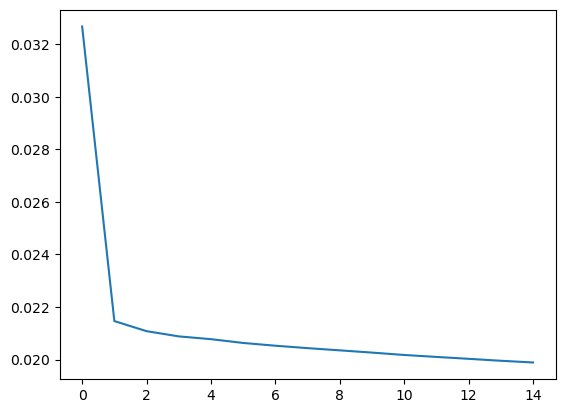

In [7]:
plt.plot(bm.as_numpy(trainer.get_hist_metric()))
plt.show()

## Testing

  0%|          | 0/25 [00:00<?, ?it/s]

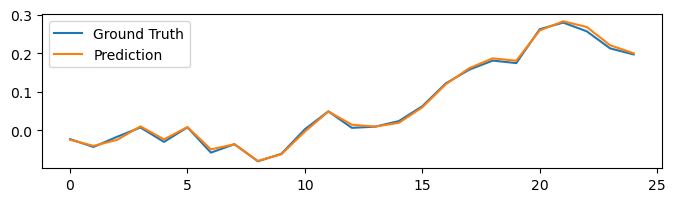

In [8]:
model.reset_state(1)
x, y = build_inputs_and_targets(batch_size=1)
predicts = trainer.predict(x)

plt.figure(figsize=(8, 2))
plt.plot(bm.as_numpy(y[0]).flatten(), label='Ground Truth')
plt.plot(bm.as_numpy(predicts[0]).flatten(), label='Prediction')
plt.legend()
plt.show()